# DORIS Range-Rate Observation Equation (Simplistic Approach)

We can formulate range-rate observation equations using the Doppler count data extracted from the DORIS RINEX files. A simplistic approach (disregarding all errors) would be to use the simple equation:

$$ \frac{\phi (t_2) - \phi (t_1)}{\Delta t} \cdot \frac{c}{f} = \frac{\rho (t_2) - \rho (t_1)}{\Delta t} $$ in [m/sec], where $\rho (t)$ is the beacon-to-satellite distance.

In [2]:
# import dsoclasses
import datetime
import attotime
import numpy as np
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere import gmf, gpt3, tropo
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math

We will need onr DORIS RINEX file and a corresponding sp3.

In [3]:
drinex = "/home/geosere/Desktop/data/s6arx24001.001"
dsp3 = "/home/geosere/Desktop/data/ssas6a20.b23357.e24001.DG_.sp3.001"

We will also need a meteorological data GPT3 file (Global Pressure Temperature File)

In [4]:
gpt3_file = "/home/geosere/Desktop/data/gpt3_5.grd"

We will also need an interpolator to compute satellite state at any observation epoch.

In [5]:
sp3 = sp3c.Sp3(dsp3)
satid = sp3.sat_ids[0]
sp3_data = sp3.get_satellite(satid, True)
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

Intitialize the `DorisRinex` instance and select a beacon (Dionysos/DIOB).
The following block calculates the residuals accounting for: 
    1) Ionospheric correction (uses ionospheric corrected L3 band + phase).
    2) Uses a smoothed frequency offset data set to correct the frequency error.
    3) Accounts for the correction of abberation error.

In [6]:
rnx = DorisRinex(drinex)

# DIOB DORIS beacon
diob = 'D31'

# approx. DIOB coordinats, see https://ids-doris.org/network/sitelogs/station.html?code=DIONYSOS
diob_xyz=np.array([4595212.468, 2039473.691, 3912617.891])

In [7]:
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()
print(f"[DEBUG] DIOB φ: {np.degrees(lat):.6f}°, λ: {np.degrees(lon):.6f}°, h: {hgt:.2f} m")

def azele(rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

[DEBUG] DIOB φ: 38.078445°, λ: 23.932882°, h: 512.79 m


In [10]:
# initially, no previous phase observation ...
t1=None
satx_prev = None 
saty_prev = None 
satz_prev = None

# store results here 
t = []; res2=[]; t_all = []; F_all = []; raw_obs = [];

k_diob = 32    #shift factor for DIOB beacon
feN2, feN4 = beacon_nominal_frequency(k_diob)
print(f"feN2 (2 GHz channel) = {feN2:.9f} Hz")
print(f"feN4 (400 MHz channel) = {feN4:.9f} Hz")

frN = ((feN2**2 - feN4**2) / (feN2 - feN4))
sf = (feN2 / feN4)**2
feN_L3 = (sf * feN2 - math.sqrt(sf) * feN4) / (sf - 1)


# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            t_all.append(at2pt(t2))
            #get frequency offset from block
            F = data['F']['value']
            F_all.append(F)

t0 = t_all[0]
t_seconds = [(ti - t0).total_seconds() for ti in t_all]

smoothing_coeffs = np.polyfit(t_seconds, F_all, 4)
F_smooth_fn = np.poly1d(smoothing_coeffs)

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == diob:
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            # satellite position at the current epoch (taking into account signal travel time)
            satx, saty, satz, _, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp, None)
            rsat2 = np.array([satx, saty, satz])
            # tropospheric delay
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(np.array((satx, saty, satz)), np.array(diob_xyz))
            dT = tropo.tropo_delay(np.array(diob_xyz), t2, el, gpt3_file)
            
            # L1 and L2 measurements
            L2_1 = data['L1']['value']
            L2_2 = data['L2']['value']
            #L3 build
            L3 = (sf*L2_1 - math.sqrt(sf)*L2_2)/(sf-1)
            
            # --- Λειασμένη συχνότητα F
            t2_sec = (at2pt(t2) - t0).total_seconds()
            F_smoothed = F_smooth_fn(t2_sec)
            #print(f"{frT:.3f} {frN:.3f}")
            # --- frT με βάση την λειασμένη F
            frT = frN * (1 + F_smoothed * 1e-11)
            
            # beacon-to-satellite distance
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            # if we have a previous measurement, within 10 sec ...
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                # computed range-rate
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                # observed range-rate
                orr = (((L3 - L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) + frT - frN) * (299792458.0 / feN_L3)
                # very loose outlier detection
                if abs(orr - crr) > 100.:
                    pass
                else:
                    t.append(at2pt(t2))
                    res2.append(orr - crr)
                    raw_obs.append({
                        'rsat1': np.array([satx_prev, saty_prev, satz_prev]),
                        'rsat2': rsat2,
                        'dt': (float((t2-t1).total_nanoseconds()) * 1e-9),
                        'v_obs': orr,
                        'dT': dT,
                    })
            # prepare for next measurement
            r1 = r2
            t1 = t2
            L1 = L3
            satx_prev, saty_prev, satz_prev = satx, saty, satz

feN2 (2 GHz channel) = 2036272526.264190674 Hz
feN4 (400 MHz channel) = 401254438.877105713 Hz
[DEBUG] Παρατήρηση: el = 0.008035 m
[DEBUG] Παρατήρηση: el = 0.007919 m
[DEBUG] Παρατήρηση: el = 0.007850 m
[DEBUG] Παρατήρηση: el = 0.007642 m
[DEBUG] Παρατήρηση: el = 0.007534 m
[DEBUG] Παρατήρηση: el = 0.007237 m
[DEBUG] Παρατήρηση: el = 0.007090 m
[DEBUG] Παρατήρηση: el = 0.110679 m
[DEBUG] Παρατήρηση: el = 0.117568 m
[DEBUG] Παρατήρηση: el = 0.120539 m
[DEBUG] Παρατήρηση: el = 0.127518 m
[DEBUG] Παρατήρηση: el = 0.130529 m
[DEBUG] Παρατήρηση: el = 0.137601 m
[DEBUG] Παρατήρηση: el = 0.140652 m
[DEBUG] Παρατήρηση: el = 0.147818 m
[DEBUG] Παρατήρηση: el = 0.150910 m
[DEBUG] Παρατήρηση: el = 0.158173 m
[DEBUG] Παρατήρηση: el = 0.161307 m
[DEBUG] Παρατήρηση: el = 0.168670 m
[DEBUG] Παρατήρηση: el = 0.171847 m
[DEBUG] Παρατήρηση: el = 0.179310 m
[DEBUG] Παρατήρηση: el = 0.182531 m
[DEBUG] Παρατήρηση: el = 0.190097 m
[DEBUG] Παρατήρηση: el = 0.193362 m
[DEBUG] Παρατήρηση: el = 0.201033 m
[DEBU

In [ ]:
# Αρχική εκτίμηση beacon (π.χ. DIOB)
n_biases = 2
x0 = np.append(np.array(diob_xyz, dtype=float), np.zeros(n_biases))  # [x, y, z] σε ECEF

m = len(raw_obs)                      # αριθμός παρατηρήσεων
J = np.zeros((m, 5))                  # Ιακωβιανός πίνακας
dl = np.zeros(m)                      # διάνυσμα residuals

LS_ITERATIONS = 3                     # επαναλήψεις Least Squares

for ls_iteration in range(LS_ITERATIONS):
    for i, obs in enumerate(raw_obs):
        rsat1 = obs['rsat1']
        rsat2 = obs['rsat2']
        dt = obs['dt']
        v_obs = obs['v_obs']
        dT = obs['dT']
        r_beacon = x0[0:3]
        delta_f = x0[3]
        delta_T = x0[4]


        # υπολογισμός θεωρητικής ταχύτητας
        r1 = np.linalg.norm(rsat1 - r_beacon)
        r2 = np.linalg.norm(rsat2 - r_beacon)
        v_theo = (r2 - r1) / dt

        # residual
        dl[i] = v_obs - delta_f - delta_T - v_theo

        # παράγωγος του v_theo ως προς x, y, z beacon (γραμμή του Ιακωβιανού)
        J[i, 0:3] = (r_beacon - rsat2) / (r2 * dt) - (r_beacon - rsat1) / (r1 * dt)
        J[i, 3] = +1.0
        J[i, 4] = +1.0

    # least squares επίλυση
    dx, *_ = np.linalg.lstsq(J, dl, rcond=None)
    x0 += dx

    # a-posteriori σφάλμα μονάδας βάρους
    sigma = np.sqrt(np.sum(dl**2) / (m - 3))

    print(f"Iteration {ls_iteration+1}: Δx = ({dx[0]:+.3f}, {dx[1]:+.3f}, {dx[2]:+.3f}) | Δf = {dx[3]:+.6f} | σ = {sigma:.3f}")
    print(f"m = {m}, n = {J.shape[1]}")


Plot residuals

#for i in range(len(res2)):
#    print(res1[i] - res2[i])
print("len(t):", len(t))
print("len(res1):", len(res1))


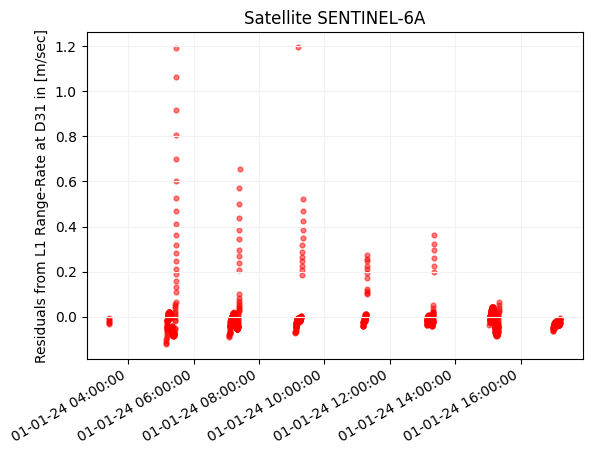

In [18]:
#plt.scatter([at2pt(ti) for ti in t], res2, alpha=0.5, s=12, c='blue')
plt.scatter([at2pt(ti) for ti in t], dl, alpha=0.5, s=12, c='red')
# plt.plot([at2pt(ti) for ti in t], res, alpha=0.3, linewidth=1)

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

## Correlation with Elevation

In [30]:
t1=None
els = []; res=[];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            satx, saty, satz, _, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp, None)
            L2 = data['L1']['value']
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(np.array((satx, saty, satz)), np.array(diob_xyz))
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                if abs(orr - crr) > 100.:
                    pass
                else:
                    res.append(orr - crr)
                    els.append(np.degrees(el))
            r1 = r2
            t1 = t2
            L1 = L2

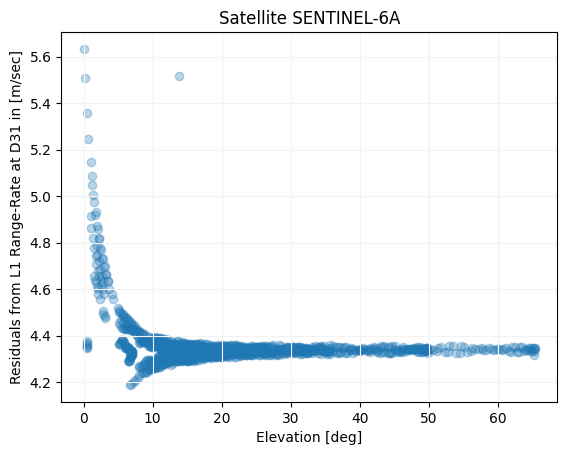

In [28]:
plt.scatter(els, res, alpha=0.3, marker='o')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.xlabel("Elevation [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.show()